Есть датасет.
Собран он следующим образом:

- Из логов были взяты пары ([запрос] - [объект на который кликнул пользователь]). Это положительные примеры (метка 1 в датасете)
- Для каждого запроса был подобран в пару негативный объект (метка 0) следующим образом: определяем к какой рубрике относится положительный пример; выбираем случайный объект из другой рубрики. Идея в том, что этот пример маловероятно будет релевантным.

На этих данных, используя кросс-валидацию, обучались различные модели. Метрики качества были хорошими.
При попытки тестирования на реальных данных, качество моделей сильно уступало тестовым метрикам. 

Задача: выявить особенности датасета, которые приводили к данным результатам и объяснить почему так происходило.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(rc={'figure.figsize':(16, 12)})
sns.set_style("whitegrid")
pd.options.display.float_format = '{:.4f}'.format

In [2]:
df = pd.read_csv('data/clicks_dataset_msk_20230101_20230725_spec.csv', names=['q', 'o', 'target']) # q = query; o = object

In [3]:
df.head()

,q,o,target
0,1590973,168299,1
1,1590973,718560,0
2,1234953,325828,1
3,1234953,135968,0
4,3326557,334526,1


Target:
- 1: поисковый запрос - клик пользователем на какой то объект
- 0: поисковый запрос - рандомно подобранный пример из другой категории (маловероятно, что релевантный пример)

In [4]:
df.shape

(12979882, 3)

In [5]:
print('Кол-во уникальных запросов:', df.q.nunique())
print('Кол-во уникальных объектов:', df.o.nunique())
print('Баланс классов:', df.target.mean())

Кол-во уникальных запросов: 4520364
Кол-во уникальных объектов: 1154540
Баланс классов: 0.5


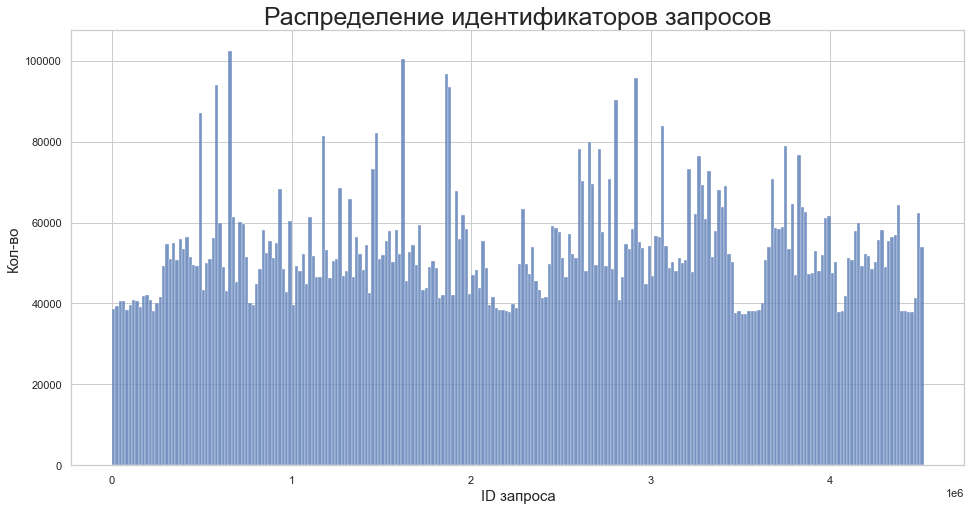

In [6]:
plt.figure(figsize=(16,8))
sns.histplot(x='q', data=df)
plt.title('Распределение идентификаторов запросов', size=25)
plt.xlabel('ID запроса', size=15)
plt.ylabel('Кол-во', size=15)
plt.show()

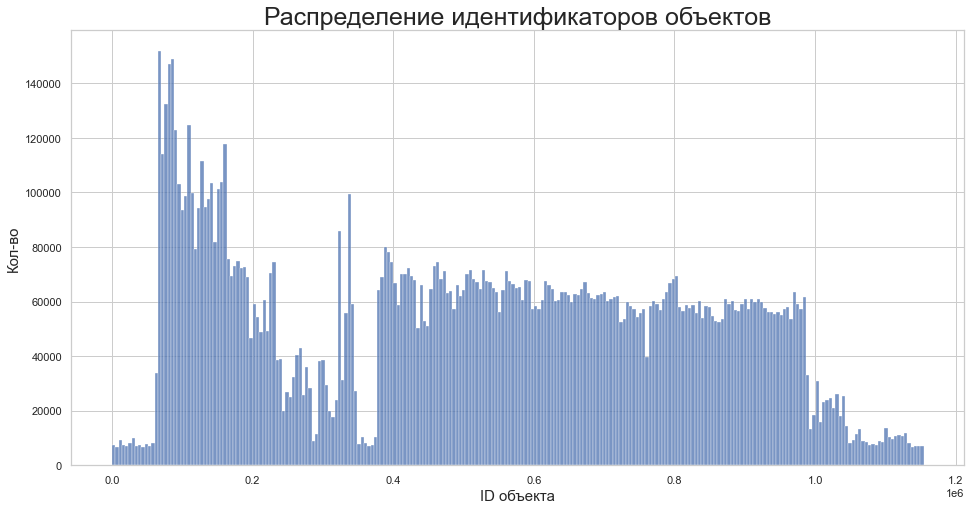

In [7]:
plt.figure(figsize=(16,8))
sns.histplot(x='o', data=df)
plt.title('Распределение идентификаторов объектов', size=25)
plt.xlabel('ID объекта', size=15)
plt.ylabel('Кол-во', size=15)
plt.show()

Диапазоны идентификатора запросов равномернее распределены, чем айдишники объектов.

## Обзор запросов

In [8]:
df2 = (
  df
  .groupby('q', as_index=False)
  .agg(
    n = ('o', 'count'),
    n_dist_obj = ('o', 'nunique'),
    avg_target = ('target', 'mean'))
)

df2 = (
    df2
    .assign(
        count_zeros = df2.n * (1 - df2.avg_target),
        count_ones = df2.n * df2.avg_target,
        only_ones = np.where(df2.avg_target == 1, 1, 0)
    )
)

In [9]:
df2.head()

,q,n,n_dist_obj,avg_target,count_zeros,count_ones,only_ones
0,0,2,2,0.5000,1.0000,1.0000,0
1,1,2,2,0.5000,1.0000,1.0000,0
2,2,2,2,0.5000,1.0000,1.0000,0
3,3,2,2,0.5000,1.0000,1.0000,0
4,4,2,2,0.5000,1.0000,1.0000,0


In [10]:
df2.n.describe()

count   4520364.0000
mean          2.8714
std          44.4862
min           2.0000
25%           2.0000
50%           2.0000
75%           2.0000
max       31864.0000
Name: n, dtype: float64

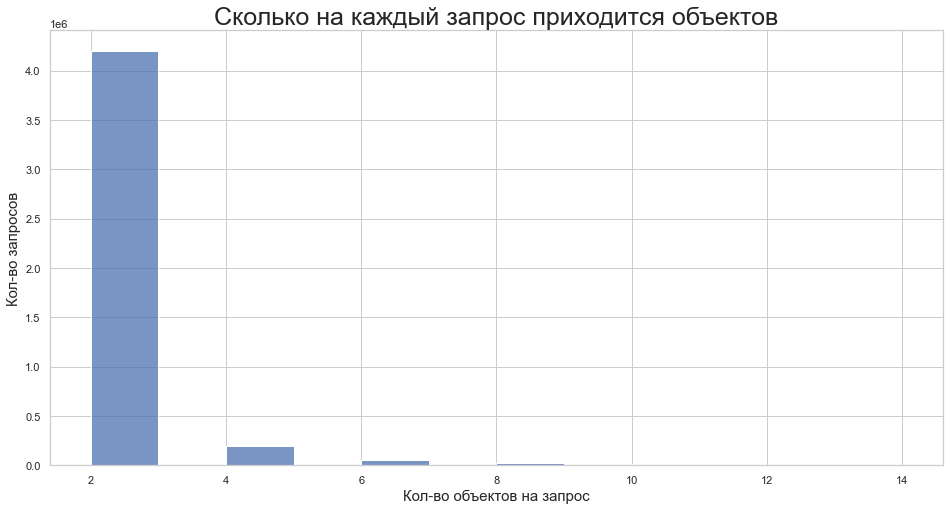

In [11]:
plt.figure(figsize=(16,8))
sns.histplot(x='n', data=df2[df2.n < 15], binwidth=1)
plt.title('Сколько на каждый запрос приходится объектов', size=25)
plt.xlabel('Кол-во объектов на запрос', size=15)
plt.ylabel('Кол-во запросов', size=15)
plt.show()

Большинство запросов имеет 2 объекта (с положительным и отрицательным классом)

## Обзор объектов

In [12]:
df3 = (
  df
  .groupby('o', as_index=False)
  .agg(
    n = ('q', 'count'),
    n_dist_obj = ('q', 'nunique'),
    avg_target = ('target', 'mean'))
)

df3 = (
    df3
    .assign(
        count_zeros = df3.n * (1 - df3.avg_target),
        count_ones = df3.n * df3.avg_target,
        only_ones = np.where(df3.avg_target == 1, 1, 0)
    )
)

In [13]:
df3.head()

,o,n,n_dist_obj,avg_target,count_zeros,count_ones,only_ones
0,0,10,10,1.0000,0.0000,10.0000,1
1,1,1,1,1.0000,0.0000,1.0000,1
2,2,2,2,1.0000,0.0000,2.0000,1
3,3,1,1,1.0000,0.0000,1.0000,1
4,4,2,2,1.0000,0.0000,2.0000,1


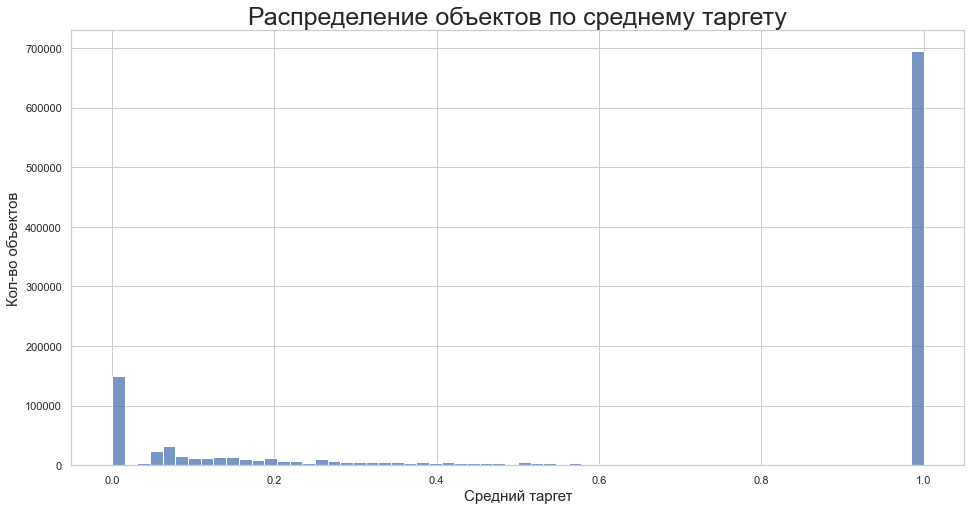

In [14]:
plt.figure(figsize=(16,8))
sns.histplot(x='avg_target', data=df3)
plt.title('Распределение объектов по среднему таргету', size=25)
plt.xlabel('Средний таргет', size=15)
plt.ylabel('Кол-во объектов', size=15)
plt.show()

In [15]:
print('Доля объектов, которые имеют только "положительный" класс: ', round(df3[df3.avg_target == 1].shape[0] / df3.shape[0], 2))

Доля объектов, которые имеют только "положительный" класс:  0.6


* Объекты крайне неравномерно распределены по среднему таргету.
* Есть большая доля объектов (60%), по которым в данных не встречается отрицательного класса (только "единички")

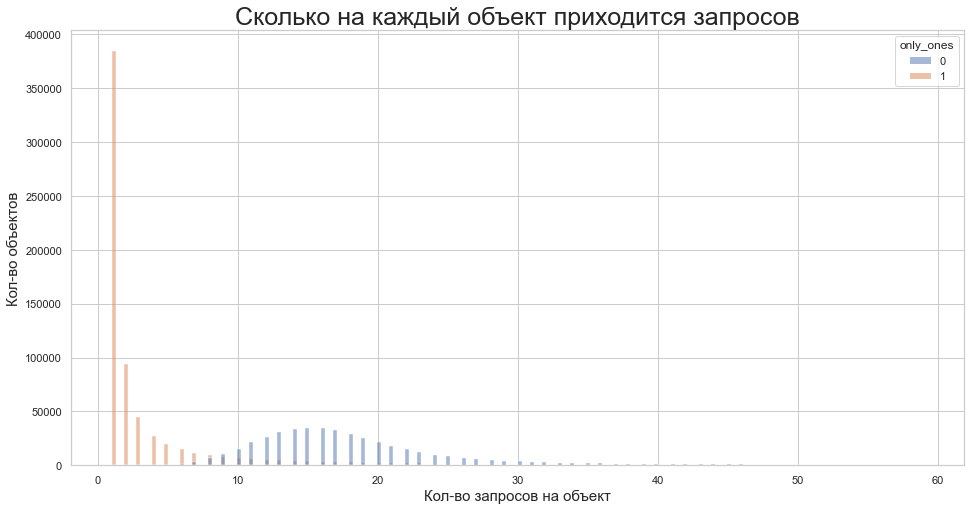

In [16]:
plt.figure(figsize=(16,8))
sns.histplot(x='n', data=df3[df3.n < 60], hue='only_ones')
plt.title('Сколько на каждый объект приходится запросов', size=25)
plt.xlabel('Кол-во запросов на объект', size=15)
plt.ylabel('Кол-во объектов', size=15)
plt.show()

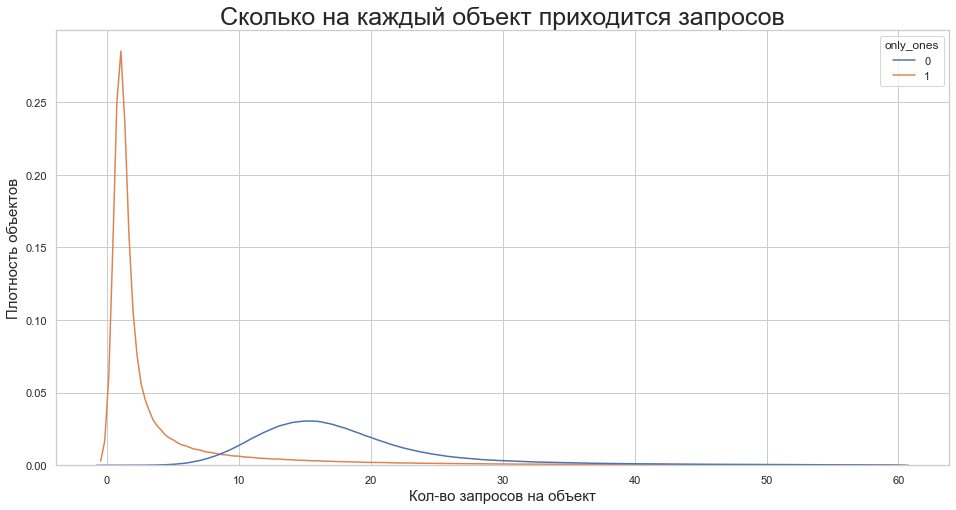

In [17]:
plt.figure(figsize=(16,8))
sns.kdeplot(x='n', data=df3[df3.n < 60], hue='only_ones')
plt.title('Сколько на каждый объект приходится запросов', size=25)
plt.xlabel('Кол-во запросов на объект', size=15)
plt.ylabel('Плотность объектов', size=15)
plt.show()

## Выводы

* Объекты только с положительным классом попадали на меньшее кол-во запросов.
* Объекты с отрицательным классом сильнее размыты по разным запросам (менее специфичны). 

То есть объекты только с положительным классом специфичны и встречаются только в рамках своей рубрики. И не попадают в отрицательный класс для других запросов/рубрик. При этом их много.
А объекты с отрицательным классом чаще попадают в разные рубрики